In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import numpy as np
import os 

In [2]:
class SPDRePCA:
    def __init__(self, spd_data, n_components):
        self.data = spd_data
        self.n_components = n_components
        self._pca = PCA(n_components=self.n_components)
        self.wavelengths = np.arange(360, 831)
        self.mu = np.array([415, 445, 480, 515, 555, 590, 630, 680])
        self.sigma = np.array([11.0403, 12.7388, 15.2866, 16.5605, 16.5605, 16.9851, 21.2314, 22.0807])

    def Reconstructed_spectrum(self):
        self.scores = self._pca.fit_transform(self.data)
        self.filters = np.zeros((len(self.mu), len(self.wavelengths)))
        for i in range(8):
            self.filters[i] = np.exp(-0.5 * ((self.wavelengths - self.mu[i]) / self.sigma[i])**2)
        self.M = np.dot(self.filters, self.scores)
        self.response_matrix = np.dot(self.filters, self.data)
        self.mean_response = np.mean(self.response_matrix, axis=1)
        self.mean_response = self.mean_response.reshape(-1, 1)
        self.M_inv = np.linalg.inv(self.M)
        response_diff = self.response_matrix - self.mean_response
        self.a_hat = np.dot(self.M_inv, response_diff)
        mean_spd = np.mean(self.data, axis=1)
        self.reconstructed_spectrum = np.dot(self.scores, self.a_hat) + mean_spd[:, np.newaxis]
        return self.reconstructed_spectrum

    def Evaluate(self, Light, save_path=None, name = None):
        s = self.data[:, Light]
        s_re = self.reconstructed_spectrum[:, Light]
        MAE = np.mean(np.absolute(s - s_re))
        RMSE = np.sqrt(np.mean(np.square(s - s_re)))
        RRMSE = RMSE / np.mean(s_re)

        # GFC
        num = abs(np.sum(s * s_re))
        denom_s = np.sqrt(np.sum(s ** 2) + 1e-9)
        denom_s_re = np.sqrt(np.sum(s_re ** 2) + 1e-9)
        GFC = num / (denom_s * denom_s_re)

        if save_path:
            with open(save_path, 'a') as f:
                f.write(f"{name} Light: {Light + 1}\n")
                f.write(f"MAE: {MAE}\n")
                f.write(f"RMSE: {RMSE}\n")
                f.write(f"RRMES: {RRMSE}\n")
                f.write(f"GFC: {GFC}\n\n")
            print(f"Results saved to {save_path}")

    def Plot(self, Light, save_path=None):
        # 创建一个包含三个子图的图像
        fig, axs = plt.subplots(3, 1)
        s = self.data[:, Light]
        r = self.reconstructed_spectrum[:, Light]

        # 绘制真实光谱图
        axs[0].plot(self.wavelengths, s, label='True Spectrum')
        axs[0].set_xlabel('Wavelength (nm)')
        axs[0].set_ylabel('Intensity')
        axs[0].set_title('True Spectrum vs Reconstructed Spectrum')
        axs[0].legend()

        # 绘制重建光谱图
        axs[1].plot(self.wavelengths, r, label='Reconstructed Spectrum')
        axs[1].set_xlabel('Wavelength (nm)')
        axs[1].set_ylabel('Intensity')
        axs[1].legend()

        # 绘制重建光谱和真实光谱叠加的图
        axs[2].plot(self.wavelengths, s, label='True Spectrum')
        axs[2].plot(self.wavelengths, r, label='Reconstructed Spectrum')
        axs[2].set_xlabel('Wavelength (nm)')
        axs[2].set_ylabel('Intensity')
        axs[2].legend()

        if save_path:
            file_name = f"Light_s{Light + 1}.png"
            plt.savefig(os.path.join(save_path, file_name))

        plt.tight_layout()
        plt.show()

In [3]:
data = np.load("/Users/dongtianchi/Documents/GIT/SpectralReconstruction/ComputationalSpectrometers/MachineLearning/cleandata.npy", allow_pickle=True)

In [4]:
from sklearn.cluster import KMeans

n_clusters = 2  # 将数据集分为两个簇
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(data.T)


/opt/anaconda3/envs/ForEXE/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [5]:
#2簇
cluster_data = [data[:, cluster_labels == i] for i in range(n_clusters)]


In [ ]:
n_components = 8  # 设置PCA的主成分数
reconstructed_spectra_clusters = []

for i, data in enumerate(cluster_data):
    spdre_pca = SPDRePCA(data, n_components)
    reconstructed_spectrum = spdre_pca.Reconstructed_spectrum()
    reconstructed_spectra_clusters.append(reconstructed_spectrum)
    


In [6]:
x1 = cluster_data[0]
x2 = cluster_data[1]
print(x1.shape)
print(x2.shape)


(471, 904)
(471, 590)


In [ ]:
with open('output_Cluster/results_cluster.txt', 'w') as f:
    f.write('')

In [7]:
r1 = SPDRePCA(x1,8)
r1.Reconstructed_spectrum()
Re1 = r1.reconstructed_spectrum

In [8]:
Re1.shape

(471, 904)

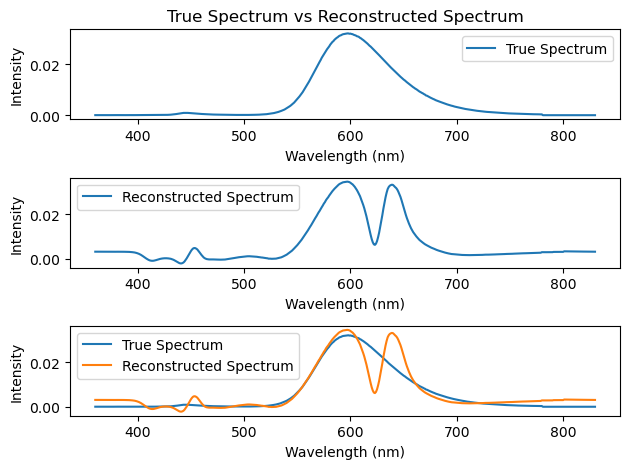

Results saved to output_Cluster/results_cluster.txt


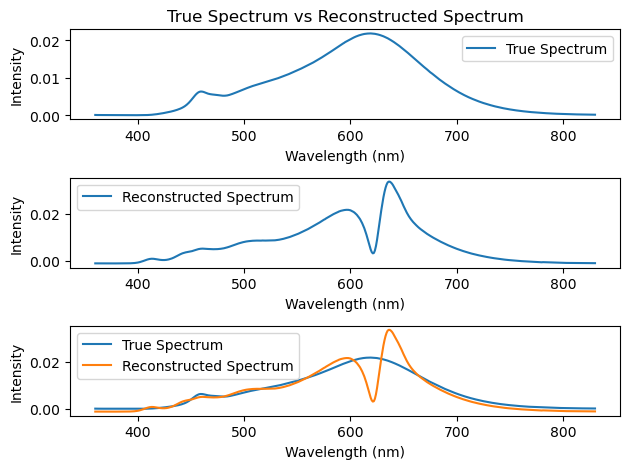

Results saved to output_Cluster/results_cluster.txt


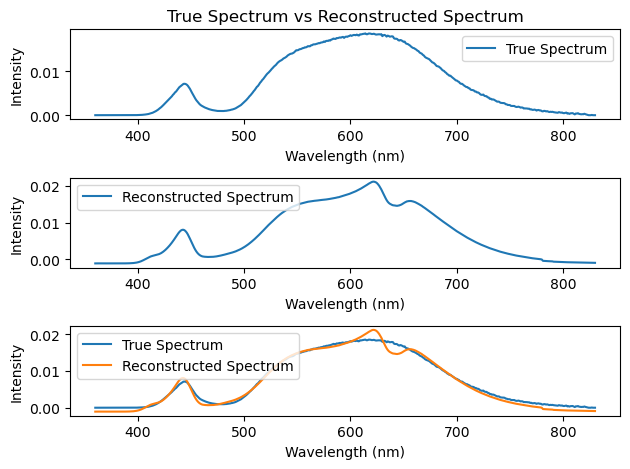

Results saved to output_Cluster/results_cluster.txt


In [13]:
list = [0,100,400]

for i in list:
    r1.Plot(i, 'output_Cluster' )
    r1.Evaluate( i, "output_Cluster/results_cluster.txt", "Cluster 1")

In [10]:
x2.shape

(471, 590)

In [11]:
r2 = SPDRePCA(x2,8)
r2.Reconstructed_spectrum()
Re2 = r2.reconstructed_spectrum
Re2.shape

(471, 590)

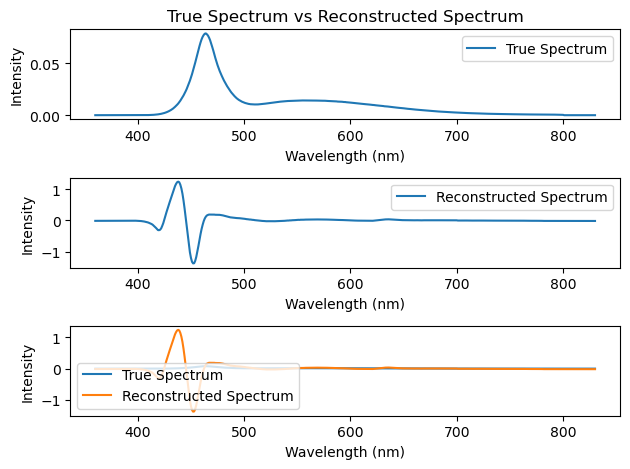

Results saved to output_Cluster/results_cluster.txt


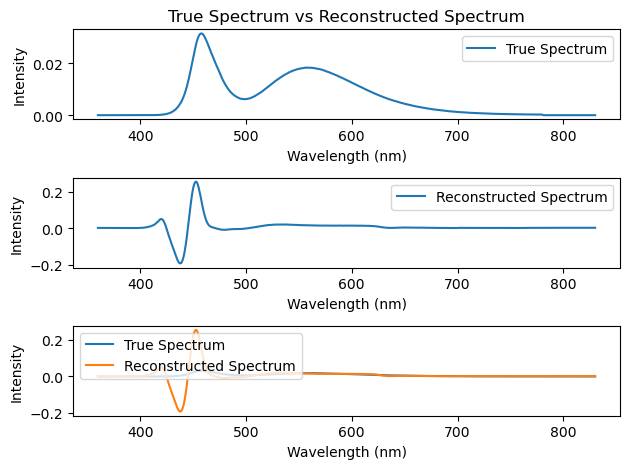

Results saved to output_Cluster/results_cluster.txt


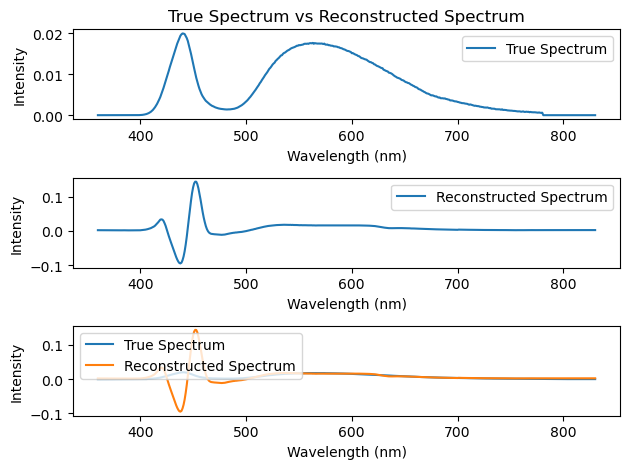

Results saved to output_Cluster/results_cluster.txt


In [14]:
list = [-1,-101,-401]

for i in list:
    r2.Plot(i, 'output_Cluster' )
    r2.Evaluate( i, "output_Cluster/results_cluster.txt", "Cluster 2")

In [17]:
Re_SPD = np.concatenate((Re1,Re2),axis=1)
cluster_SPD = np.concatenate((x1,x2),axis=1)
print(Re_SPD.shape)
print(cluster_SPD.shape)

(471, 1494)
(471, 1494)


In [19]:
R = SPDRePCA(cluster_SPD,8)
R.Reconstructed_spectrum()


array([[0.0023803454144792086, -0.0020318179760855696,
        -0.0008651219898714051, ..., -0.008981994927997625,
        -0.012887562864481424, -0.00988896383812208],
       [0.0023795355073026802, -0.0020068085736298794,
        -0.0008445088957505952, ..., -0.008904407655746344,
        -0.012626302818350648, -0.00980432603085],
       [0.0023767210506436473, -0.0020172472200713776,
        -0.0008533240901039044, ..., -0.008946609818332925,
        -0.012723261188299948, -0.009849953151574217],
       ...,
       [0.0024446276162611745, -0.0018732665388891839,
        -0.0007237777770882026, ..., -0.008920390715976511,
        -0.01299960256496266, -0.009826600566720158],
       [0.002430262144635198, -0.0018880047429680976,
        -0.0007384297071047474, ..., -0.008937243714001336,
        -0.013002437589572629, -0.009844705462820283],
       [0.002424258620958317, -0.001897857986625756,
        -0.0007473273102296631, ..., -0.00894621928081225,
        -0.01303664023304728, -0.

In [ ]:
with open('output_ClusterPCA/results_cluster.txt', 'w') as f:
    f.write('')

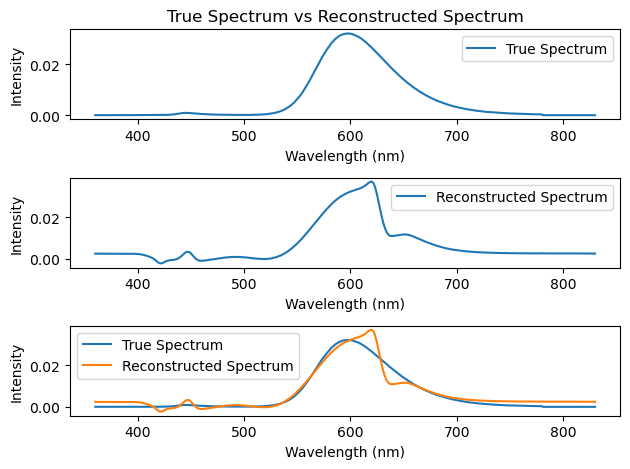

Results saved to output_ClusterPCA/results_cluster.txt


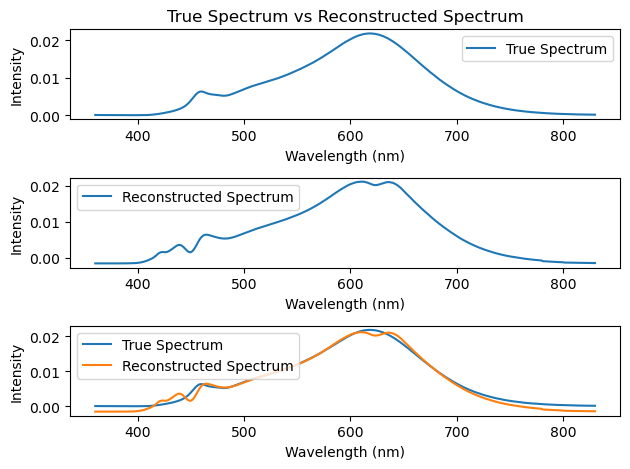

Results saved to output_ClusterPCA/results_cluster.txt


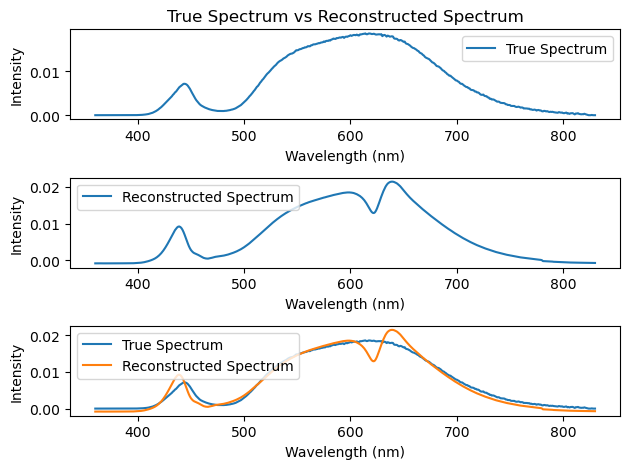

Results saved to output_ClusterPCA/results_cluster.txt


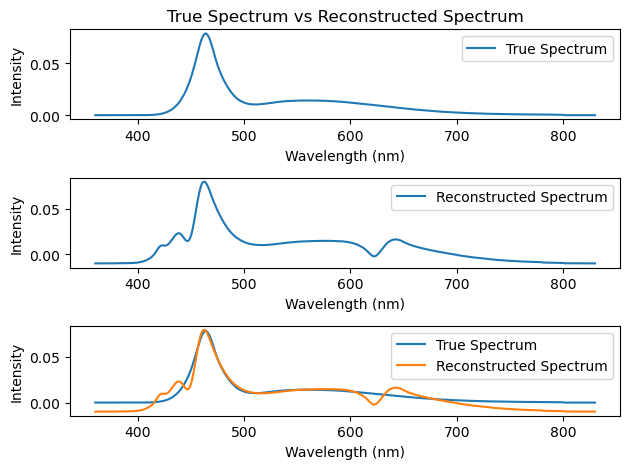

Results saved to output_ClusterPCA/results_cluster.txt


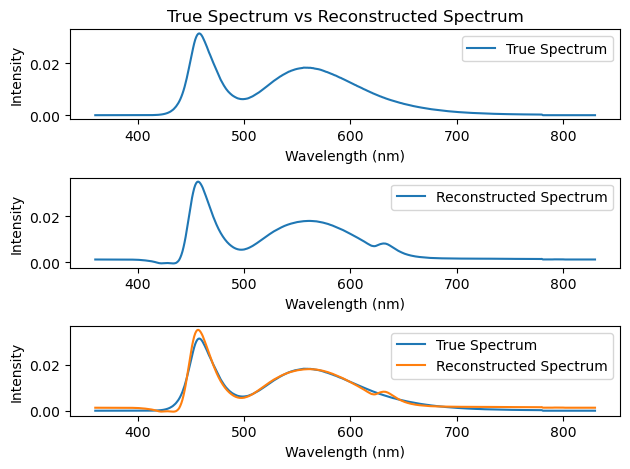

Results saved to output_ClusterPCA/results_cluster.txt


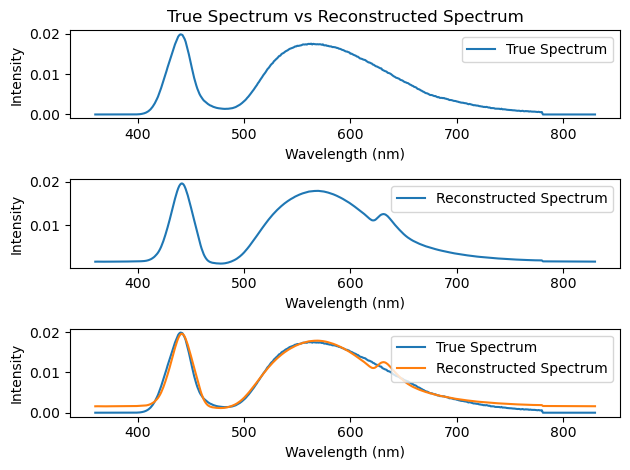

Results saved to output_ClusterPCA/results_cluster.txt


In [20]:
list = [0,100, 400 ,-1,-101,-401]

for i in list:
    R.Plot(i, 'output_ClusterPCA' )
    R.Evaluate(i, "output_ClusterPCA/results_cluster.txt")
    

整体评估

print(range)

In [28]:
for i in range(3):
    print(i)

0
1
2


In [33]:
def Evaluate(data, re_data, save_path=None, name = None):
        MAE_list = []
        RMSE_list = []
        GFC_list = []

        
        for i in range(1494):
            s = data[:, i]
            s_re = re_data[:, i]
            MAE = np.mean(np.absolute(s - s_re))
            RMSE = np.sqrt(np.mean(np.square(s - s_re)))
            RRMSE = RMSE / np.mean(s_re)

            # GFC
            num = abs(np.sum(s * s_re))
            denom_s = np.sqrt(np.sum(s ** 2) + 1e-9)
            denom_s_re = np.sqrt(np.sum(s_re ** 2) + 1e-9)
            GFC = num / (denom_s * denom_s_re)

            MAE_list.append(MAE)
            RMSE_list.append(RMSE)
            GFC_list.append(GFC)

        MAE_result = np.mean(MAE_list)
        RMSE_result = np.mean(RMSE_list)
        GFC_result = np.mean(GFC_list)


        if save_path:
            with open(save_path, 'a') as f:
                f.write(f"TOTlE: {name}\n")
                f.write(f"MAE_TOTLE: {MAE_result}\n")
                f.write(f"RMSE_TOTLE: {RMSE_result}\n")
                f.write(f"GFC_TOTLE: {GFC_result}\n\n")
            print(f"Results saved to {save_path}")

        return MAE_result, RMSE_result, GFC_result


In [34]:
Cluster_MAE, Cluser_RMSE, Cluster_GFC = Evaluate(cluster_SPD, Re_SPD,"output_Cluster/results_cluster.txt")


Results saved to output_Cluster/results_cluster.txt


In [35]:
PCA_R = R.reconstructed_spectrum

In [38]:
PCA_MAE, PCA_RMSE, PCA_GFC = Evaluate(cluster_SPD, PCA_R,"output_ClusterPCA/results_cluster.txt")

Results saved to output_ClusterPCA/results_cluster.txt
